In [1]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Mlxtend libraries
from mlxtend.feature_selection import SequentialFeatureSelector

# Scikit Learn Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           precision_score, recall_score, f1_score)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

# Model Deployment Libraries
import joblib

In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/bank-personal-loan/Bank_Personal_Loan_Modelling(1).csv")
df['CCAvg'] = df['CCAvg'].str.replace('/', '.', regex=False).astype(float)

In [3]:
# Basic info about the dataset
print("\nDataset Info:")
print(f"Shape: {df.shape}")
print("\nData Types:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Check for duplicates
print(f"\nDuplicated rows: {df.duplicated().sum()}")

# Target variable distribution
print(f"\nTarget variable distribution:")
print(df['Personal Loan'].value_counts())
print(f"Loan approval rate: {df['Personal Loan'].mean():.2%}")


Dataset Info:
Shape: (5000, 14)

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB

First 5 r

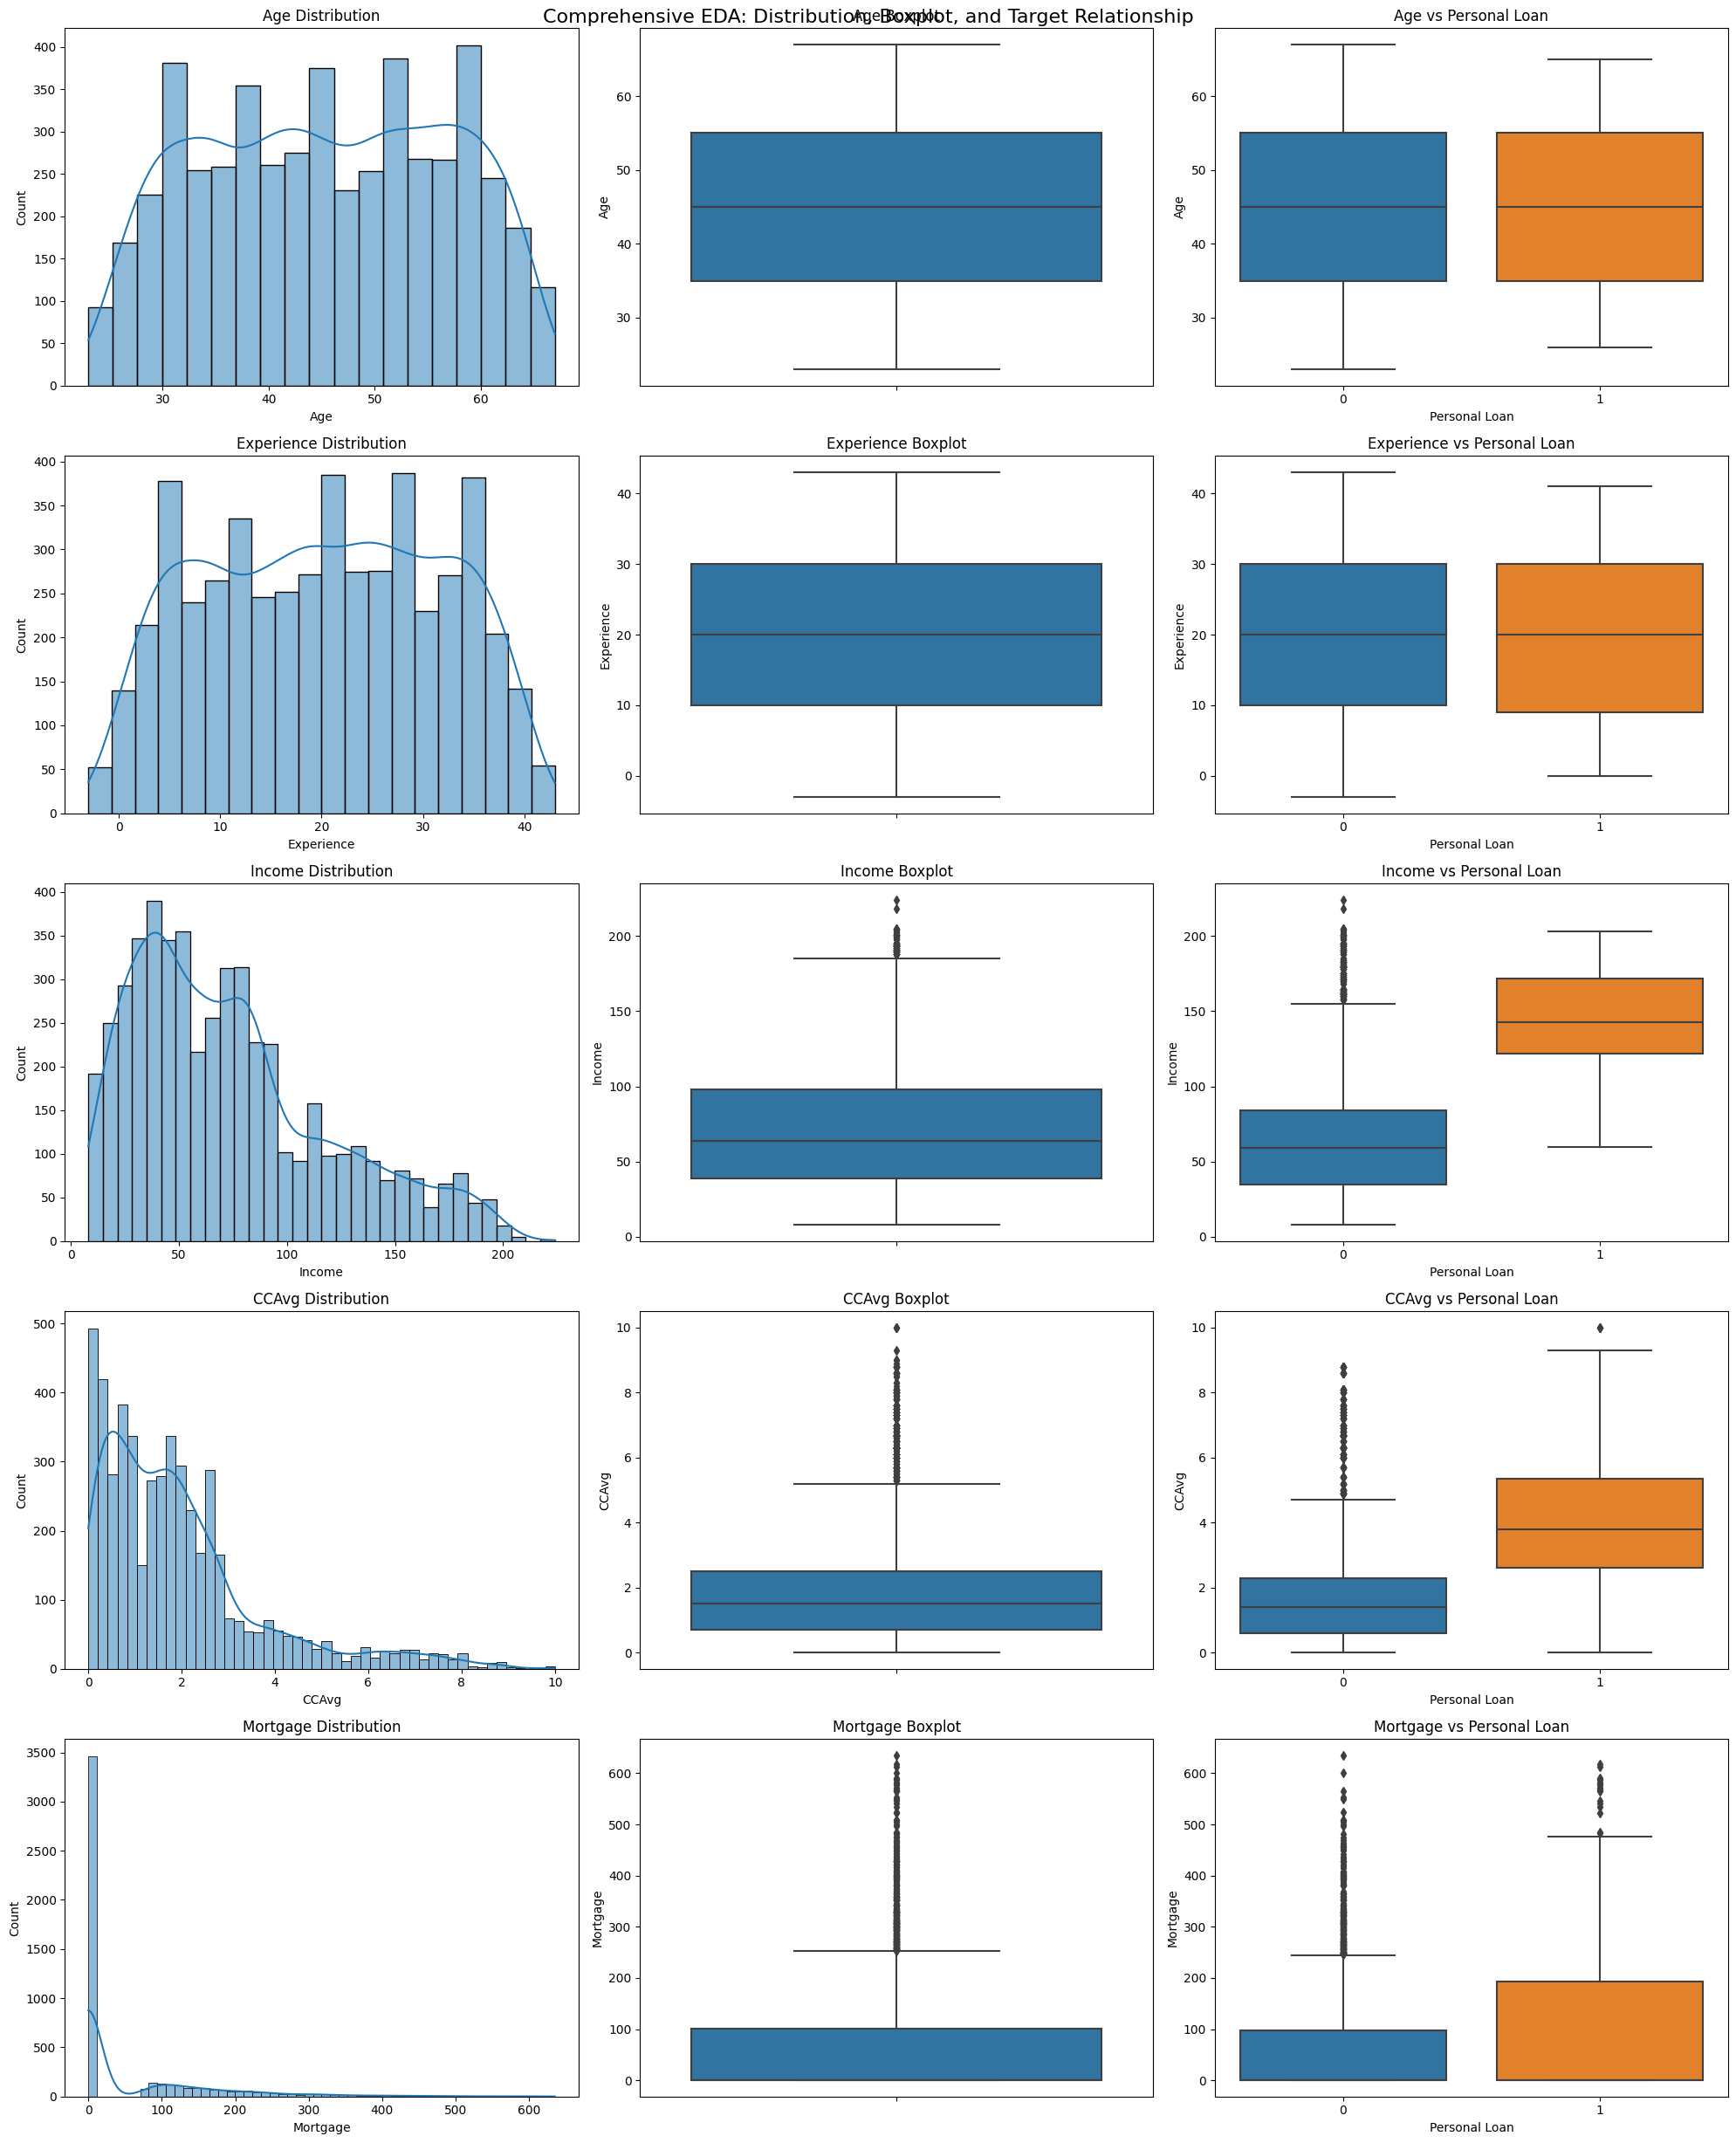


Correlation Analysis:


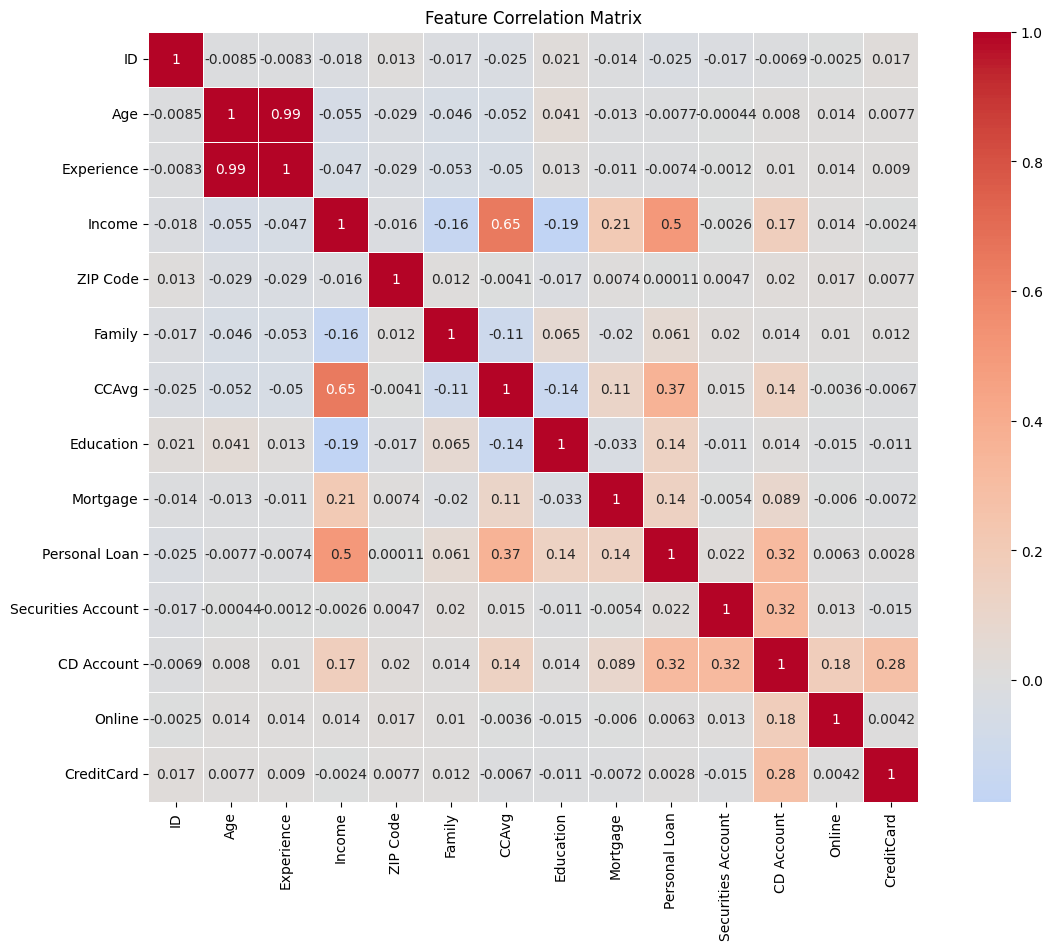


Features correlation with Personal Loan:
Personal Loan         1.000000
Income                0.502462
CCAvg                 0.366889
CD Account            0.316355
Mortgage              0.142095
Education             0.136722
Family                0.061367
Securities Account    0.021954
Online                0.006278
CreditCard            0.002802
ZIP Code              0.000107
Experience           -0.007413
Age                  -0.007726
ID                   -0.024801
Name: Personal Loan, dtype: float64


In [4]:
# Define numerical columns for analysis
numerical_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']

# Create comprehensive EDA plots
fig, axes = plt.subplots(len(numerical_cols), 3, figsize=(20, 5*len(numerical_cols)))
fig.suptitle('Comprehensive EDA: Distribution, Boxplot, and Target Relationship', fontsize=16)

for i, col in enumerate(numerical_cols):
    # Distribution plot
    sns.histplot(data=df, x=col, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} Distribution')
    
    # Boxplot
    sns.boxplot(data=df, y=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} Boxplot')
    
    # Relationship with target
    sns.boxplot(data=df, x='Personal Loan', y=col, ax=axes[i, 2])
    axes[i, 2].set_title(f'{col} vs Personal Loan')

plt.tight_layout()
plt.show()

# Correlation analysis
print("\nCorrelation Analysis:")
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Target correlation
target_corr = df.corr()['Personal Loan'].sort_values(ascending=False)
print(f"\nFeatures correlation with Personal Loan:")
print(target_corr)

In [5]:
def detect_outliers_iqr(df, columns):
    """Detect outliers using IQR method"""
    outlier_indices = set()
    outlier_counts = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_counts[col] = len(col_outliers)
        outlier_indices.update(col_outliers)
    
    return outlier_indices, outlier_counts

# Detect outliers
outlier_indices, outlier_counts = detect_outliers_iqr(df, numerical_cols)

print(f"\nOutlier Analysis:")
print(f"Total outlier instances: {len(outlier_indices)}")
print("Outliers per column:")
for col, count in outlier_counts.items():
    print(f"  {col}: {count} outliers ({count/len(df)*100:.1f}%)")

# Create dataset without outliers for comparison
df_no_outliers = df.drop(index=outlier_indices).reset_index(drop=True)
print(f"\nDataset size after outlier removal: {df_no_outliers.shape}")
print(f"Removed {len(df) - len(df_no_outliers)} rows ({(len(df) - len(df_no_outliers))/len(df)*100:.1f}%)")


Outlier Analysis:
Total outlier instances: 602
Outliers per column:
  Age: 0 outliers (0.0%)
  Experience: 0 outliers (0.0%)
  Income: 96 outliers (1.9%)
  CCAvg: 324 outliers (6.5%)
  Mortgage: 291 outliers (5.8%)

Dataset size after outlier removal: (4398, 14)
Removed 602 rows (12.0%)


In [6]:
# Prepare features (excluding target and non-predictive columns)
X = df.drop(['Personal Loan', 'ID'], axis=1, errors='ignore')
y = df['Personal Loan']

print(f"Features used: {list(X.columns)}")

# Standardize features for selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Method 1: SelectKBest with f_classif
print("\n1. SelectKBest Feature Selection:")
selector_kbest = SelectKBest(f_classif, k=5)
X_kbest = selector_kbest.fit_transform(X_scaled, y)
selected_features_kbest = X.columns[selector_kbest.get_support()].tolist()
print(f"Selected features: {selected_features_kbest}")

# Method 2: Variance Threshold
print("\n2. Variance Threshold Feature Selection:")
selector_var = VarianceThreshold(threshold=0.1)
X_var = selector_var.fit_transform(X_scaled)
selected_features_var = X.columns[selector_var.get_support()].tolist()
print(f"Features after variance threshold: {selected_features_var}")

# Method 3: Sequential Feature Selection
print("\n3. Sequential Feature Selection (this may take a moment...):")
sfs = SequentialFeatureSelector(
    LogisticRegression(max_iter=1000), 
    k_features=5, 
    forward=False, 
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
sfs.fit(X_scaled, y)
selected_features_sfs = list(X.columns[list(sfs.k_feature_idx_)])
print(f"Sequential selection features: {selected_features_sfs}")

# Compare feature selection methods with cross-validation
print("\n4. Comparing Feature Selection Methods:")
methods = {
    'All Features': X_scaled,
    'SelectKBest (5)': X_kbest,
    'Variance Threshold': X_var,
    'Sequential Selection': X_scaled[:, list(sfs.k_feature_idx_)]
}

lr = LogisticRegression(max_iter=1000)
for method_name, X_method in methods.items():
    scores = cross_val_score(lr, X_method, y, cv=5, scoring='accuracy')
    print(f"{method_name:20s}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Features used: ['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

1. SelectKBest Feature Selection:
Selected features: ['Income', 'CCAvg', 'Education', 'Mortgage', 'CD Account']

2. Variance Threshold Feature Selection:
Features after variance threshold: ['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

3. Sequential Feature Selection (this may take a moment...):
Sequential selection features: ['Income', 'Family', 'Education', 'CD Account', 'CreditCard']

4. Comparing Feature Selection Methods:
All Features        : 0.9514 (+/- 0.0072)
SelectKBest (5)     : 0.9452 (+/- 0.0110)
Variance Threshold  : 0.9514 (+/- 0.0072)
Sequential Selection: 0.9500 (+/- 0.0089)


In [7]:
# Use the best performing feature set (SelectKBest in this case)
X_final = df[selected_features_var]
y_final = df['Personal Loan']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.3, random_state=42, stratify=y_final
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Standardize the features
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)

Training set size: (3500, 12)
Test set size: (1500, 12)


In [8]:
print("\n1. Logistic Regression:")
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    lr_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)
lr_grid.fit(X_train_scaled, y_train)

print(f"Best LR parameters: {lr_grid.best_params_}")
print(f"Best CV score: {lr_grid.best_score_:.4f}")

lr_best = lr_grid.best_estimator_
y_pred_lr = lr_best.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Test accuracy: {lr_accuracy:.4f}")


1. Logistic Regression:
Best LR parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.9506
Test accuracy: 0.9513


In [9]:
print("\n2. Decision Tree:")
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 16)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42), 
    dt_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_iter=50,
    n_jobs=-1,
    random_state=42
)
dt_grid.fit(X_train, y_train)  # Decision trees don't need scaling

print(f"Best DT parameters: {dt_grid.best_params_}")
print(f"Best CV score: {dt_grid.best_score_:.4f}")

dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Test accuracy: {dt_accuracy:.4f}")


2. Decision Tree:
Best DT parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'criterion': 'entropy'}
Best CV score: 0.9809
Test accuracy: 0.9887


In [10]:
print("\n3. Random Forest:")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    rf_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_iter=50,
    n_jobs=-1,
    random_state=42
)
rf_grid.fit(X_train, y_train)

print(f"Best RF parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Test accuracy: {rf_accuracy:.4f}")


3. Random Forest:
Best RF parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV score: 0.9846
Test accuracy: 0.9887



4. Validation Curve Analysis for Decision Tree:


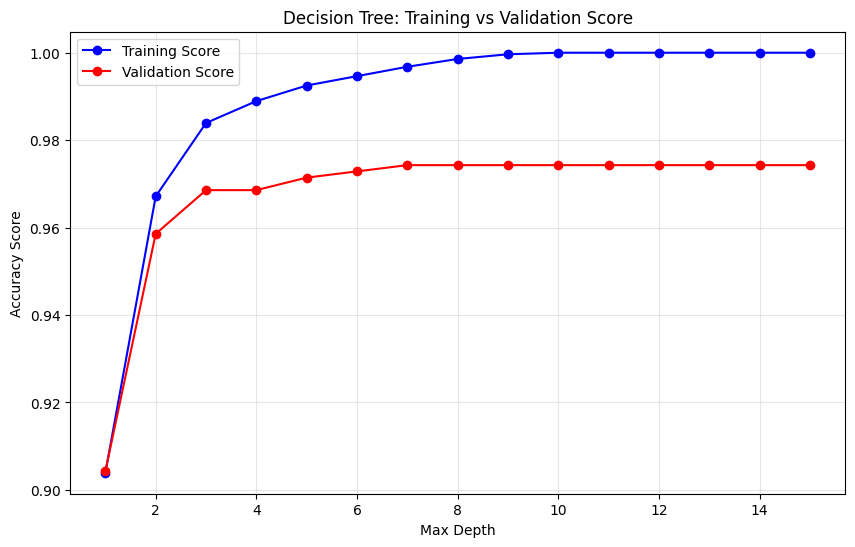

Optimal max_depth based on validation: 7


In [11]:
print("\n4. Validation Curve Analysis for Decision Tree:")
max_depth_range = range(1, 16)
train_scores = []
val_scores = []

# Split training data further for validation curve
X_train_val, X_val_val, y_train_val, y_val_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

for depth in max_depth_range:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train_val, y_train_val)
    
    train_pred = dt_temp.predict(X_train_val)
    val_pred = dt_temp.predict(X_val_val)
    
    train_scores.append(accuracy_score(y_train_val, train_pred))
    val_scores.append(accuracy_score(y_val_val, val_pred))

# Plot validation curves
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_scores, 'o-', label='Training Score', color='blue')
plt.plot(max_depth_range, val_scores, 'o-', label='Validation Score', color='red')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title('Decision Tree: Training vs Validation Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

optimal_depth = max_depth_range[np.argmax(val_scores)]
print(f"Optimal max_depth based on validation: {optimal_depth}")

In [12]:
models = {
    'Logistic Regression': (lr_best, y_pred_lr, X_test_scaled),
    'Decision Tree': (dt_best, y_pred_dt, X_test),
    'Random Forest': (rf_best, y_pred_rf, X_test)
}

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV_Mean', 'CV_Std'])

for i, (model_name, (model, y_pred, X_test_data)) in enumerate(models.items()):
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_test_data, y_test, cv=5, scoring='accuracy')
    
    # Store results
    results_df.loc[i] = [model_name, accuracy, precision, recall, f1, cv_scores.mean(), cv_scores.std()]
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  CV Score:  {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Display results table
print(f"\n{'='*80}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*80}")
print(results_df.round(4).to_string(index=False))

# Find the best model
best_model_idx = results_df['Accuracy'].astype(float).idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name}")


Logistic Regression Results:
  Accuracy:  0.9513
  Precision: 0.8142
  Recall:    0.6389
  F1-Score:  0.7160
  CV Score:  0.9520 (+/- 0.0172)

Decision Tree Results:
  Accuracy:  0.9887
  Precision: 0.9320
  Recall:    0.9514
  F1-Score:  0.9416
  CV Score:  0.9873 (+/- 0.0195)

Random Forest Results:
  Accuracy:  0.9887
  Precision: 0.9774
  Recall:    0.9028
  F1-Score:  0.9386
  CV Score:  0.9847 (+/- 0.0090)

MODEL COMPARISON SUMMARY
              Model  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std
Logistic Regression    0.9513     0.8142  0.6389    0.7160   0.9520  0.0086
      Decision Tree    0.9887     0.9320  0.9514    0.9416   0.9873  0.0098
      Random Forest    0.9887     0.9774  0.9028    0.9386   0.9847  0.0045

Best performing model: Decision Tree


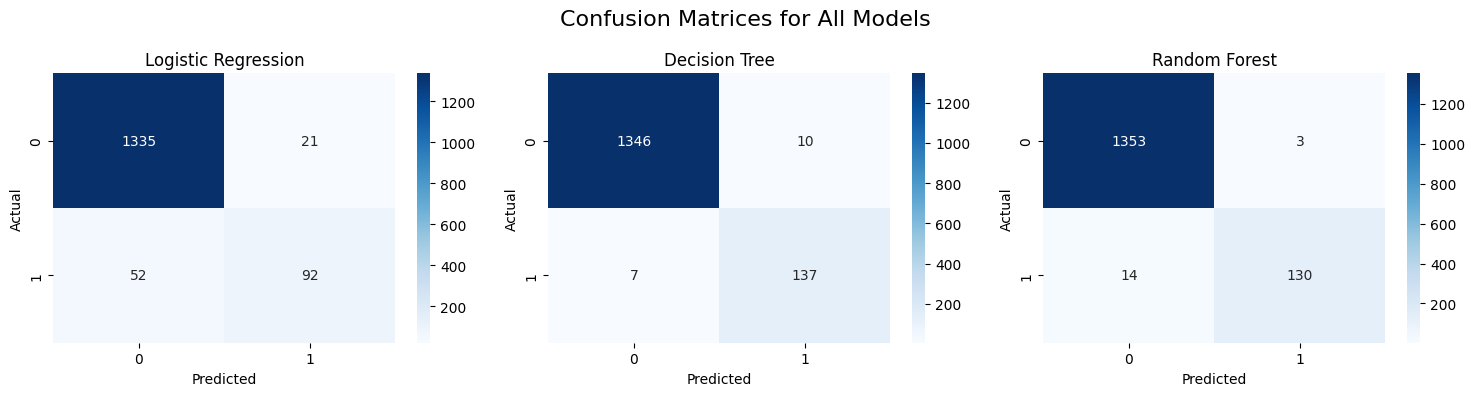

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices for All Models', fontsize=16)

for i, (model_name, (model, y_pred, X_test_data)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


Random Forest Feature Importance:
               feature  importance
2               Income    0.334217
6            Education    0.178249
5                CCAvg    0.166043
4               Family    0.123809
9           CD Account    0.050521
0                  Age    0.034073
7             Mortgage    0.034055
1           Experience    0.031553
3             ZIP Code    0.031455
11          CreditCard    0.006635
10              Online    0.005582
8   Securities Account    0.003808


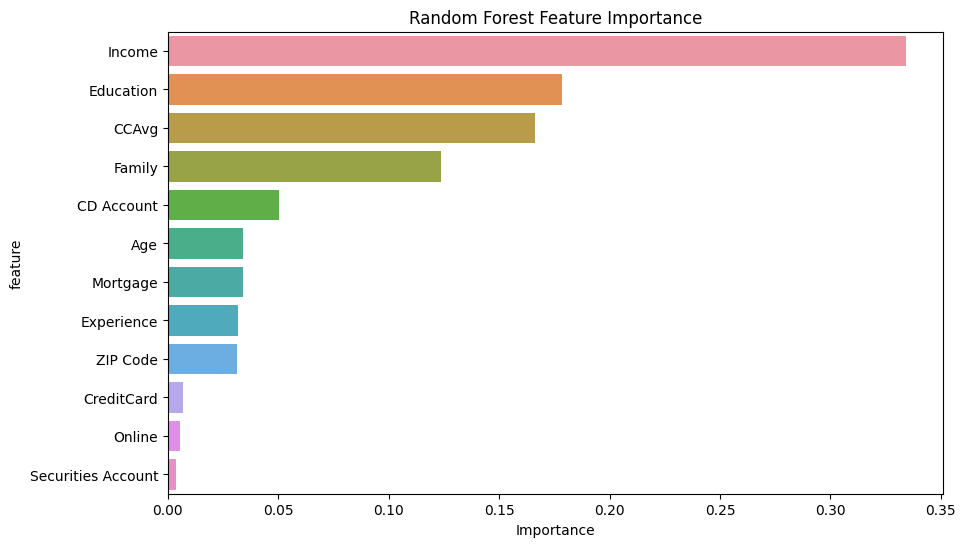


Decision Tree Feature Importance:
               feature  importance
2               Income    0.574962
6            Education    0.197508
4               Family    0.127204
5                CCAvg    0.088954
9           CD Account    0.006867
0                  Age    0.004504
1           Experience    0.000000
3             ZIP Code    0.000000
7             Mortgage    0.000000
8   Securities Account    0.000000
10              Online    0.000000
11          CreditCard    0.000000


In [14]:
# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': selected_features_var,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importance, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.show()

# Decision Tree Feature Importance
dt_importance = pd.DataFrame({
    'feature': selected_features_var,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nDecision Tree Feature Importance:")
print(dt_importance)

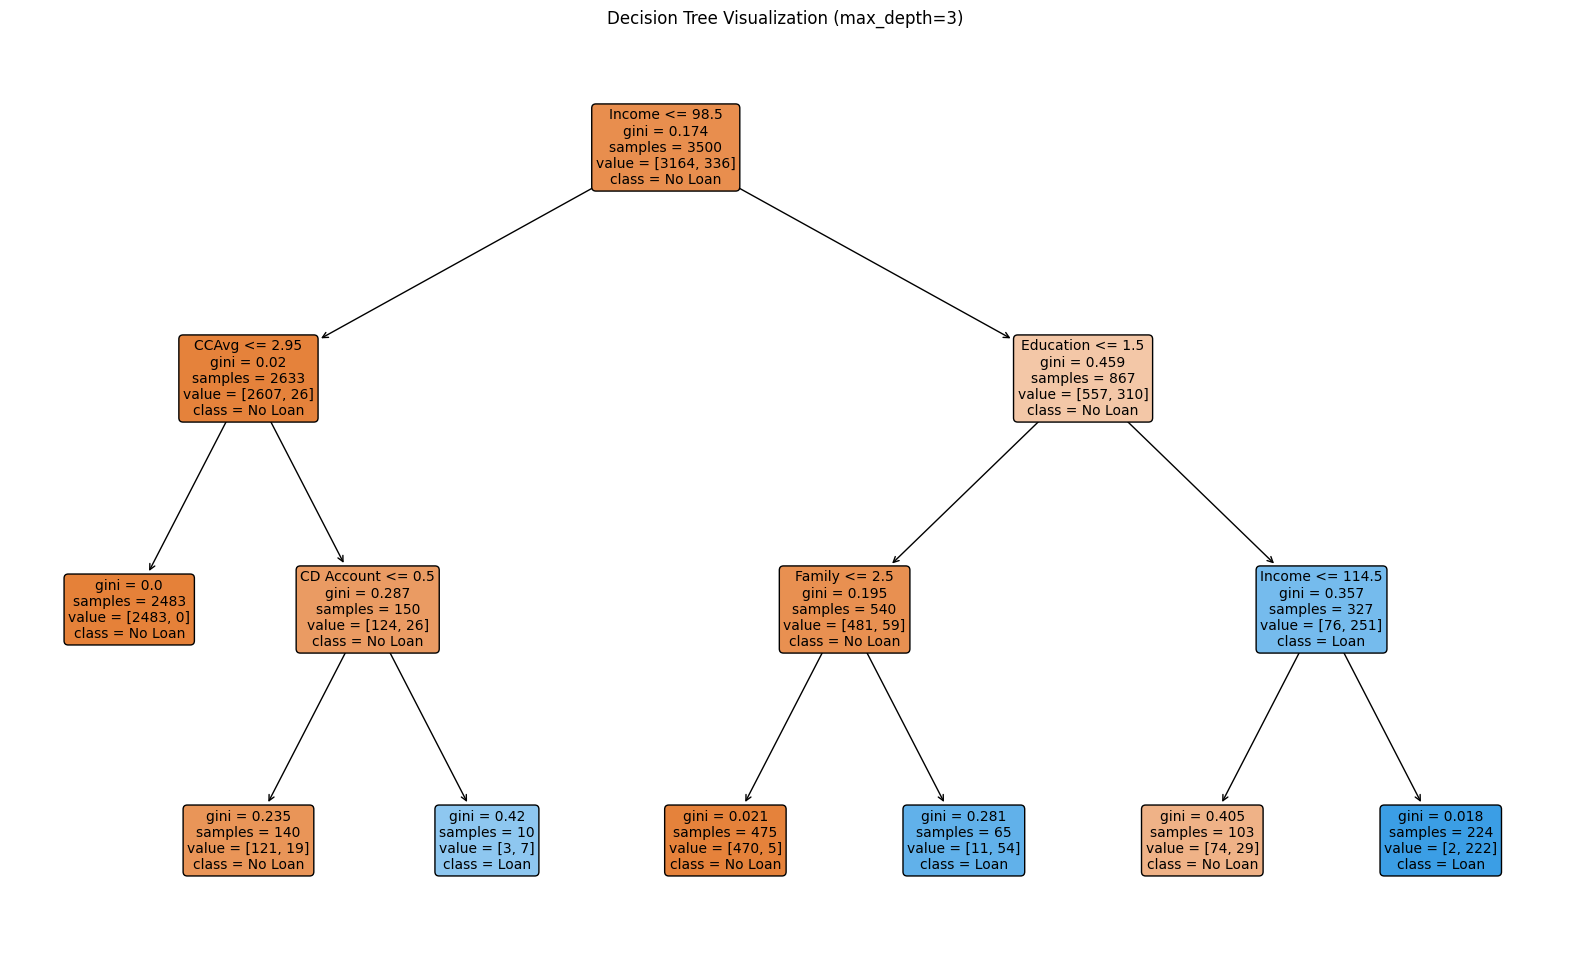

In [15]:
# Create a simplified decision tree for visualization
dt_simple = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_simple.fit(X_train, y_train)

plt.figure(figsize=(20, 12))
tree.plot_tree(dt_simple, 
               feature_names=selected_features_var,
               class_names=['No Loan', 'Loan'],
               filled=True,
               rounded=True,
               fontsize=10)
plt.title('Decision Tree Visualization (max_depth=3)')
plt.show()

In [16]:
# Save the best model and scaler
best_model = models[best_model_name][0]
model_filename = f"best_{best_model_name.lower().replace(' ', '_')}_model.pkl"
scaler_filename = "feature_scaler.pkl"

# Save model
joblib.dump(best_model, model_filename)
print(f"Best model ({best_model_name}) saved as: {model_filename}")

# Save scaler if needed
if best_model_name == 'Logistic Regression':
    joblib.dump(scaler_final, scaler_filename)
    print(f"Feature scaler saved as: {scaler_filename}")

# Demonstrate model loading and prediction
print(f"\nDemonstrating model deployment:")
loaded_model = joblib.load(model_filename)

# Make predictions on test set
if best_model_name == 'Logistic Regression':
    loaded_scaler = joblib.load(scaler_filename)
    test_predictions = loaded_model.predict(loaded_scaler.transform(X_test))
else:
    test_predictions = loaded_model.predict(X_test)

deployment_accuracy = accuracy_score(y_test, test_predictions)
print(f"Loaded model accuracy: {deployment_accuracy:.4f}")

Best model (Decision Tree) saved as: best_decision_tree_model.pkl

Demonstrating model deployment:
Loaded model accuracy: 0.9887


In [17]:
print(f"\n{'='*80}")
print("FINAL SUMMARY AND RECOMMENDATIONS")
print(f"{'='*80}")

print(f"""
PROJECT SUMMARY:
- Dataset size: {df.shape[0]} samples, {df.shape[1]} features
- Target variable: Personal Loan approval (imbalanced: {df['Personal Loan'].mean():.1%} approval rate)
- Features selected: {len(selected_features_kbest)} most important features
- Models tested: Logistic Regression, Decision Tree, Random Forest
- Best performing model: {best_model_name}
- Best model accuracy: {results_df.loc[best_model_idx, 'Accuracy']:.4f}

KEY INSIGHTS:
- Most important features for loan prediction: {', '.join(rf_importance.head(3)['feature'].tolist())}
- Model is ready for deployment with {deployment_accuracy:.1%} accuracy

RECOMMENDATIONS:
1. Monitor model performance regularly
2. Retrain with new data periodically
3. Consider ensemble methods for improved accuracy
4. Implement proper model validation in production
5. Add monitoring for data drift and model degradation
""")


FINAL SUMMARY AND RECOMMENDATIONS

PROJECT SUMMARY:
- Dataset size: 5000 samples, 14 features
- Target variable: Personal Loan approval (imbalanced: 9.6% approval rate)
- Features selected: 5 most important features
- Models tested: Logistic Regression, Decision Tree, Random Forest
- Best performing model: Decision Tree
- Best model accuracy: 0.9887

KEY INSIGHTS:
- Most important features for loan prediction: Income, Education, CCAvg
- Model is ready for deployment with 98.9% accuracy

RECOMMENDATIONS:
1. Monitor model performance regularly
2. Retrain with new data periodically
3. Consider ensemble methods for improved accuracy
4. Implement proper model validation in production
5. Add monitoring for data drift and model degradation

